<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

## *Data Science Unit 4 Sprint 3 Assignment 1*

# Recurrent Neural Networks and Long Short Term Memory (LSTM)

![Monkey at a typewriter](https://upload.wikimedia.org/wikipedia/commons/thumb/3/3c/Chimpanzee_seated_at_typewriter.jpg/603px-Chimpanzee_seated_at_typewriter.jpg)

It is said that [infinite monkeys typing for an infinite amount of time](https://en.wikipedia.org/wiki/Infinite_monkey_theorem) will eventually type, among other things, the complete works of Wiliam Shakespeare. Let's see if we can get there a bit faster, with the power of Recurrent Neural Networks and LSTM.

This text file contains the complete works of Shakespeare: https://www.gutenberg.org/files/100/100-0.txt

Use it as training data for an RNN - you can keep it simple and train character level, and that is suggested as an initial approach.

Then, use that trained RNN to generate Shakespearean-ish text. Your goal - a function that can take, as an argument, the size of text (e.g. number of characters or lines) to generate, and returns generated text of that size.

Note - Shakespeare wrote an awful lot. It's OK, especially initially, to sample/use smaller data and parameters, so you can have a tighter feedback loop when you're trying to get things running. Then, once you've got a proof of concept - start pushing it more!

In [0]:
import pandas as pd
import requests
import numpy as np
import random
import sys
import os

from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.layers import LSTM

In [0]:
# TODO - Words, words, mere words, no matter from the heart.

url = 'https://www.gutenberg.org/files/100/100-0.txt'

In [5]:
# Let's take a peak at what the file looks like
# Code reference https://2.python-requests.org/projects/3/user/advanced/#streaming-requests

# Counter to break the loop. This is a giant file.
# I'll print it before each line to help see the text
i = 0

r = requests.get(url, stream=True)

if r.encoding is None:
    r.encoding = 'utf-8'

for line in r.iter_lines(decode_unicode=True):
    if line:
        print(i, line)
    i+=1
    if i >= 100:
      break

0 ï»¿
1 Project Gutenbergâs The Complete Works of William Shakespeare, by William
2 Shakespeare
4 This eBook is for the use of anyone anywhere in the United States and
5 most other parts of the world at no cost and with almost no restrictions
6 whatsoever.  You may copy it, give it away or re-use it under the terms
7 of the Project Gutenberg License included with this eBook or online at
8 www.gutenberg.org.  If you are not located in the United States, youâll
9 have to check the laws of the country where you are located before using
10 this ebook.
13 Title: The Complete Works of William Shakespeare
15 Author: William Shakespeare
17 Release Date: January 1994 [EBook #100]
18 Last Updated: November 7, 2019
20 Language: English
22 Character set encoding: UTF-8
24 *** START OF THIS PROJECT GUTENBERG EBOOK THE COMPLETE WORKS OF WILLIAM SHAKESPEARE ***
29 The Complete Works of William Shakespeare
33 by William Shakespeare
38       Contents
42                THE SONNETS
44                

In [0]:
# Create a list to store each line of text

text_list = []

i = 0

r = requests.get(url, stream=True)

if r.encoding is None:
    r.encoding = 'utf-8'

for line in r.iter_lines(decode_unicode=True):
    if line:
        text_list.append(line)

In [7]:
len(text_list)

139331

In [8]:
title_1 = "THE MERCHANT OF VENICE"
title_2 = "THE MERRY WIVES OF WINDSOR"

for i in range(len( text_list)):
  if text_list[i] == title_1:
    print(title_1, "\t", i)
  
  elif text_list[i] == title_2:
    print(title_2, "\t", i)

THE MERCHANT OF VENICE 	 72947
THE MERRY WIVES OF WINDSOR 	 76305


In [0]:
merchant = ""

index_1 = 72947
index_2 = 76305

for line in text_list[index_1 : index_2]:
  merchant += line.replace("â\x80\x99s", "") + " "

In [10]:
merchant

'THE MERCHANT OF VENICE Contents ACT I Scene I. Venice. A street. Scene II. Belmont. A room in Portia house. Scene III. Venice. A public place. ACT II Scene I. Belmont. A room in Portia house. Scene II. Venice. A street. Scene III. The same. A room in Shylock house. Scene IV. The same. A street. Scene V. The same. Before Shylock house. Scene VI. The same. Scene VII. Belmont. A room in Portia house. Scene VIII. Venice. A street. Scene IX. Belmont. A room in Portia house. ACT III Scene I. Venice. A street. Scene II. Belmont. A room in Portia house. Scene III. Venice. A street. Scene IV. Belmont. A room in Portia house. Scene V. The same. A garden. ACT IV Scene I. Venice. A court of justice. Scene II. The same. A street. ACT V Scene I. Belmont. The avenue to Portia house. Dramatis PersonÃ¦ THE DUKE OF VENICE THE PRINCE OF MOROCCO, suitor to Portia THE PRINCE OF ARRAGON, suitor to Portia ANTONIO, a merchant of Venice BASSANIO, his friend, suitor to Portia GRATIANO, friend to Antonio and Ba

In [0]:
chars = list(set(merchant))

In [0]:
# Unique Characters
chars = list(set(merchant))

# Lookup Tables
char_int = {c:i for i, c in enumerate(chars)} 
int_char = {i:c for i, c in enumerate(chars)} 

In [13]:
# Create the sequence data

maxlen = 80
step = 1

encoded = [char_int[c] for c in merchant]

sequences = [] # Each element is 80 chars long
next_char = [] # One element for each sequence

for i in range(0, len(encoded) - maxlen, step):
    
    sequences.append(encoded[i : i + maxlen])
    next_char.append(encoded[i + maxlen])
    
print('sequences: ', len(sequences))


sequences:  120969


In [0]:
# Create x & y

x = np.zeros((len(sequences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sequences),len(chars)), dtype=np.bool)

for i, sequence in enumerate(sequences):
    for t, char in enumerate(sequence):
        x[i,t,char] = 1
        
    y[i, next_char[i]] = 1

In [15]:
x.shape

(120969, 80, 76)

In [16]:
y.shape

(120969, 76)

In [0]:
# build the model: a single LSTM

model = Sequential()
model.add(LSTM(128, input_shape=(maxlen, len(chars)), activation='tanh', recurrent_activation='sigmoid', dropout=0.2, recurrent_dropout=0, unroll=False, use_bias=True))
model.add(Dense(len(chars), activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam')

In [0]:
def sample(preds):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / 1
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

text = merchant

def on_epoch_end(epoch, _):
    # Function invoked at end of each epoch. Prints generated text.
    
    print()
    print('----- Generating text after Epoch: %d' % epoch)
    
    start_index = random.randint(0, len(text) - maxlen - 1)
    
    generated = ''
    
    sentence = text[start_index: start_index + maxlen]
    generated += sentence
    
    print('----- Generating with seed: "' + sentence + '"')
    sys.stdout.write(generated)
    
    for i in range(200):
        x_pred = np.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(sentence):
            x_pred[0, t, char_int[char]] = 1
            
        preds = model.predict(x_pred, verbose=0)[0]
        next_index = sample(preds)
        next_char = int_char[next_index]
        
        sentence = sentence[1:] + next_char
        
        sys.stdout.write(next_char)
        sys.stdout.flush()
    print()


print_callback = LambdaCallback(on_epoch_end=on_epoch_end)

In [30]:
# fit the model

results = model.fit(x, y,
                    batch_size=128,
                    epochs=50,
                    callbacks=[print_callback])

Epoch 1/50
942/946 [============================>.] - ETA: 0s - loss: 1.6689
----- Generating text after Epoch: 0
----- Generating with seed: "ly close it in, we cannot hear it.  Enter Musicians. Come, ho! and wake Diana wi"
ly close it in, we cannot hear it.  Enter Musicians. Come, ho! and wake Diana with that clace mering fase of like Anfontunes in the rieht Of munce; but fe tiermedied neoseved, I poye is son of halt.  [_Exit Aring onaune Sasennio__] Rear, Jessica. What if i to light less do me n
946/946 [==============================] - 13s 13ms/step - loss: 1.6691
Epoch 2/50
943/946 [============================>.] - ETA: 0s - loss: 1.6627
----- Generating text after Epoch: 1
----- Generating with seed: "! How dost thou and thy master agree? I have brought him a present. How âgree "
! How dost thou and thy master agree? I have brought him a present. How âgree an Gratia, lot heapt ruiging wites sate Thy stane deen. gold, with you, pase a master, Than so be answard to bid muil

In [19]:
# Function for graphing results

import seaborn as sns
import matplotlib.pyplot as plt

def graph_results(results, metric_list, title = "", dimensions = (6,4)):
    a4_dims = dimensions
    fig, ax = plt.subplots(figsize=a4_dims)
    plot_title="Plot of "
    
    for metric in metric_list:
        ax = sns.lineplot(x = [i for i in range(len(results.history[metric]))], y = results.history[metric])
        
        if title is graph_results.__defaults__[0]:
            plot_title += metric + ", "
        else:
            plot_title = title
    
    ax.set_title(plot_title)
    ax.set_xlabel('Epoch')
    ax.legend(metric_list)
    ax.set_ylabel("Score");

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


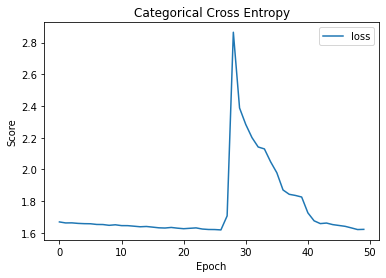

In [31]:
graph_results(results, ["loss"], title="Categorical Cross Entropy")

### That's an interesting graph.  Let's run the model again.

In [20]:
# fit the model

results2 = model.fit(x, y,
                    batch_size=128,
                    epochs=50,
                    callbacks=[print_callback])

Epoch 1/50
945/946 [============================>.] - ETA: 0s - loss: 2.8407
----- Generating text after Epoch: 0
----- Generating with seed: "Exeunt._] SCENE VIII. Venice. A street.  Enter Salarino and Solanio. SALARINO. W"
Exeunt._] SCENE VIII. Venice. A street.  Enter Salarino and Solanio. SALARINO. Wfomee)eud aifind. d tot mordt, Salp anod fin. tâRd. TSind wile?.cOLOA. I JasaatetheFd altsiiy tagin, wive to ao savhe. Tat not tirk tnin fetk wi d. bhetea nit  y. win yausbeiley. Gora Hhegenico, W aw
946/946 [==============================] - 13s 14ms/step - loss: 2.8407
Epoch 2/50
945/946 [============================>.] - ETA: 0s - loss: 2.4288
----- Generating text after Epoch: 1
----- Generating with seed: " he love me to madness, I shall never requite him. NERISSA. What say you then to"
 he love me to madness, I shall never requite him. NERISSA. What say you then to iotiogt Wist nit mntde toumy locesene Seetsene terce h mey thawise getith kfid Ism mak o cale, A aulotePthot antre c

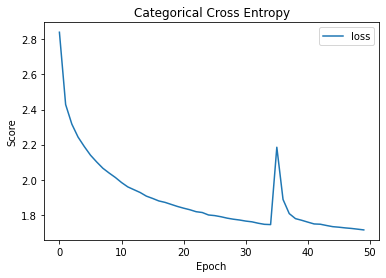

In [24]:
graph_results(results2, ["loss"], title="Categorical Cross Entropy")

In [25]:
# fit the model

results3 = model.fit(x, y,
                    batch_size=128,
                    epochs=100,
                    callbacks=[print_callback])

Epoch 1/100
946/946 [==============================] - ETA: 0s - loss: 1.7071
----- Generating text after Epoch: 0
----- Generating with seed: "ver, which this promise carries, âWho chooseth me shall get as much as he dese"
ver, which this promise carries, âWho chooseth me shall get as much as he deseeviouse And is a gived me our of I pauch f this wirco Which Mwn that a pents to begie sir, but for; in se viss came by never trop his forferlay, like you? MEnter Lorinto For I have a Chrnstala SOLANIO
946/946 [==============================] - 13s 14ms/step - loss: 1.7071
Epoch 2/100
946/946 [==============================] - ETA: 0s - loss: 1.7039
----- Generating text after Epoch: 1
----- Generating with seed: "in terms, gone to heaven. GOBBO. Marry, God forbid! The boy was the very staff o"
in terms, gone to heaven. GOBBO. Marry, God forbid! The boy was the very staff on thy staud. I cassaw you should not be branger-to wive of tallows, Somether take me is in  hrawial. If a fellow th

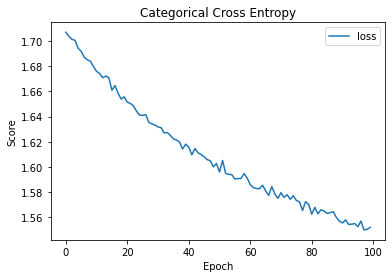

In [27]:
graph_results(results3, ["loss"], title="Categorical Cross Entropy")

# Resources and Stretch Goals

## Stretch goals:
- Refine the training and generation of text to be able to ask for different genres/styles of Shakespearean text (e.g. plays versus sonnets)
- Train a classification model that takes text and returns which work of Shakespeare it is most likely to be from
- Make it more performant! Many possible routes here - lean on Keras, optimize the code, and/or use more resources (AWS, etc.)
- Revisit the news example from class, and improve it - use categories or tags to refine the model/generation, or train a news classifier
- Run on bigger, better data

## Resources:
- [The Unreasonable Effectiveness of Recurrent Neural Networks](https://karpathy.github.io/2015/05/21/rnn-effectiveness/) - a seminal writeup demonstrating a simple but effective character-level NLP RNN
- [Simple NumPy implementation of RNN](https://github.com/JY-Yoon/RNN-Implementation-using-NumPy/blob/master/RNN%20Implementation%20using%20NumPy.ipynb) - Python 3 version of the code from "Unreasonable Effectiveness"
- [TensorFlow RNN Tutorial](https://github.com/tensorflow/models/tree/master/tutorials/rnn) - code for training a RNN on the Penn Tree Bank language dataset
- [4 part tutorial on RNN](http://www.wildml.com/2015/09/recurrent-neural-networks-tutorial-part-1-introduction-to-rnns/) - relates RNN to the vanishing gradient problem, and provides example implementation
- [RNN training tips and tricks](https://github.com/karpathy/char-rnn#tips-and-tricks) - some rules of thumb for parameterizing and training your RNN